In [9]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


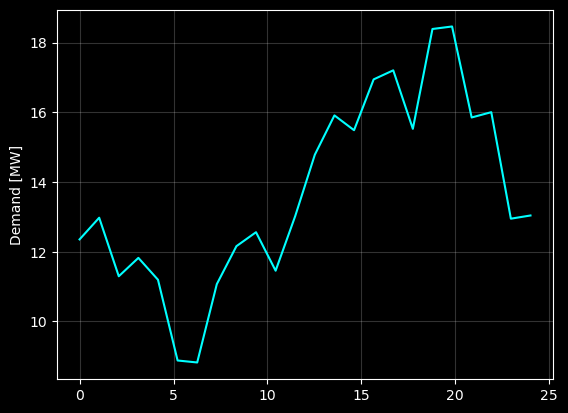

In [3]:
n_hours = 24  # hours per day
n_days = 1  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 328.16  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

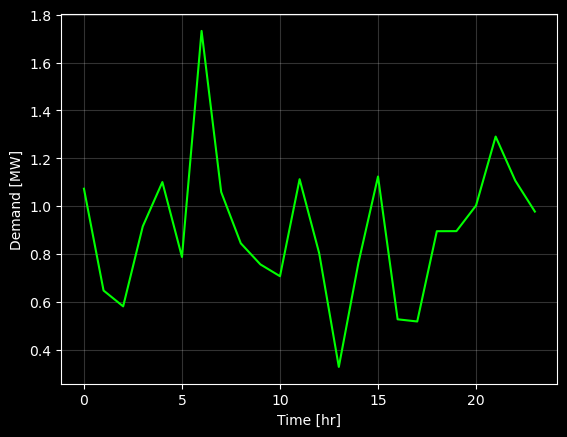

In [4]:
#creating wind profile
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()

In [5]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)

[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

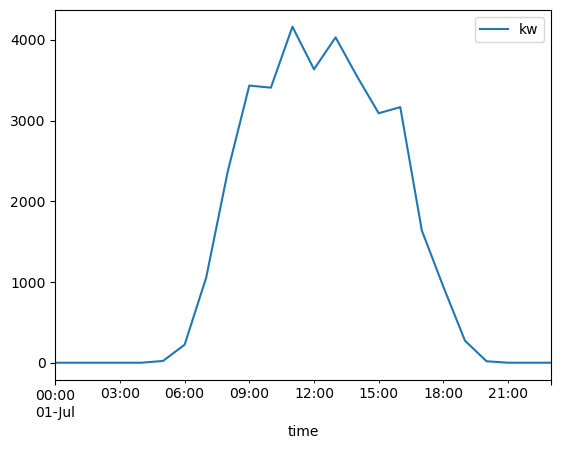

In [6]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()
solar_day_ener = [0,0,0,0,0,22.15,
                  223.25,1052.75,2368.25,3433,3406.75,4161.75,
                  3634.5,4030.25,3545,3090,3165.75,1637.75,
                  940,273.25,18.0475,0,0,0]
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])

In [7]:
solar_ener = df_solar['Energy'].values
solar_ener

array([   0.    ,    0.    ,    0.    ,    0.    ,    0.    ,   22.15  ,
        223.25  , 1052.75  , 2368.25  , 3433.    , 3406.75  , 4161.75  ,
       3634.5   , 4030.25  , 3545.    , 3090.    , 3165.75  , 1637.75  ,
        940.    ,  273.25  ,   18.0475,    0.    ,    0.    ,    0.    ])

In [8]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            wind=wind_speed,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [17]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination=('n_gen', 40),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      2 |             - |             -
     2 |       40 |      5 |  0.2974208366 |         ideal
     3 |       60 |      3 |  0.7920987360 |         ideal
     4 |       80 |      5 |  0.5961564477 |         ideal
     5 |      100 |      3 |  0.0113671261 |         ideal
     6 |      120 |      5 |  0.0192405361 |         ideal
     7 |      140 |      6 |  0.2607011781 |         ideal
     8 |      160 |      7 |  0.0499381772 |         nadir
     9 |      180 |      4 |  0.0233702233 |         ideal
    10 |      200 |      4 |  0.0643724876 |         ideal
    11 |      220 |      5 |  0.0332865301 |             f
    12 |      240 |      6 |  0.0212143637 |         ideal
    13 |      260 |     10 |  0.0098291767 |             f
    14 |      280 |     10 |  0.0295376760 |         ideal
    15 |      300 |     10 |  0.0340787045 |         ideal
    16 |      320 |      6 |  0.2181098401 |         ide

In [18]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[2.26764004e+00, 9.02573627e-05],
       [9.88878724e-01, 1.53945170e-04],
       [1.21387934e+00, 1.32057746e-04],
       [2.12136630e+00, 9.10432013e-05],
       [1.25957747e+00, 1.20452025e-04],
       [1.10983137e+00, 1.46151151e-04],
       [1.89110119e+00, 9.24467846e-05],
       [1.49754827e+00, 9.97776184e-05],
       [1.35499493e+00, 1.13046718e-04],
       [1.30107805e+00, 1.17538190e-04],
       [1.43869118e+00, 1.03182993e-04],
       [1.18008592e+00, 1.38276148e-04],
       [1.85923471e+00, 9.24662898e-05],
       [1.57561618e+00, 9.59326160e-05],
       [1.72281218e+00, 9.33042242e-05],
       [1.37786494e+00, 1.08427549e-04],
       [1.39523408e+00, 1.06633419e-04],
       [1.11661656e+00, 1.42709385e-04],
       [1.12939932e+00, 1.39116549e-04],
       [1.60271636e+00, 9.58879373e-05]])

array([[9.47014088e-01, 1.78661444e-05, 2.16281813e+00, 2.13977309e-04],
       [9.94269225e-01, 5.09186849e-05, 9.75820699e-02, 5.81161674e-03],
       [9.87885876e-01, 9.60004831e-04, 4.11631782e-01, 2.45224808e-02],
       [9.64050325e-01, 2.15193498e-05, 1.89788246e+00, 6.36764857e-03],
       [9.62695461e-01, 6.91110247e-04, 5.75742930e-01, 7.59381787e-05],
       [9.87926123e-01, 9.61582557e-04, 2.11299463e-01, 4.11069707e-02],
       [9.94261875e-01, 3.35076636e-05, 1.47475992e+00, 1.65865846e-02],
       [9.61234238e-01, 1.12456915e-03, 9.41337422e-01, 2.49438440e-03],
       [9.56488425e-01, 3.80093895e-05, 6.78910999e-01, 2.42113596e-02],
       [9.81275081e-01, 2.40514290e-05, 6.15020001e-01, 2.48651410e-04],
       [9.56488425e-01, 3.80093895e-05, 8.50164597e-01, 6.40561581e-03],
       [9.95583526e-01, 1.08634141e-03, 3.23643222e-01, 3.49673701e-02],
       [9.81999807e-01, 4.02559360e-05, 1.46914176e+00, 5.10840357e-03],
       [9.46035892e-01, 4.21591123e-05, 1.09214310e

(None, None)

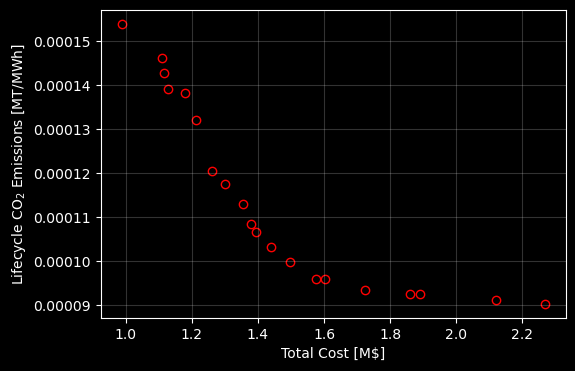

In [19]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()